In [1]:
import os
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
import nibabel as nib
from pathlib import Path
import matplotlib.pyplot as plt
from nilearn import plotting

import torch.nn.functional as F
from torch.utils.data import DataLoader

import sys
sys.path.append('/home/neuro-ml-2002/project')
from datasets import MRIDatasetImage
from utils import get_transforms
from baseline_model import Conv5_FC3


In [2]:
tsv_path = Path('10_sub_for_validation/labels_list_10')
caps = Path('10_sub_for_validation/10_sub_for_validation')
source_path = Path('10_sub_for_validation/model')  
task_diagnoses = ['AD','CN']
mask_type = None
task = '_'.join(task_diagnoses)

In [3]:
model = Conv5_FC3().eval()
model.cuda()
model_path = os.path.join(source_path, 'model_best.pth.tar')
results = torch.load(model_path, map_location='cuda')
model.load_state_dict(results['model'])

<All keys matched successfully>

In [4]:
OUTPUT_DIR = '/output'

class GetHeatmap():
    '''Aggregator class for different classic interpretation methods predictions.'''
    def __init__(self, size, save=False):
        self.size = size
        self.save = save
        if save:
            self.mask_dir = os.path.join(OUTPUT_DIR, 'img_mask')

    def grad_cam(self, model, image, logit, save_name=None):
        gc = GradCam(model)
        heatmap = gc.grad_cam(image, logit, self.size).cpu().numpy()
        
        if self.save:
            nib.save(nib.Nifti1Image(heatmap, affine=np.eye(4)),
                 os.path.join(self.mask_dir, '{}_gradcam_mask.nii.gz'.format(save_name)))
        
        return heatmap
    
    def guided_backprop(self, model, image, logit, save_name=None):
        gp = GuidedBackprop(model)
        pred = logit.data.max(1)[1].item()
        img_grad = gp.guided_backprop(image, pred)
        
        return img_grad

    def mean_pertrub(self, model, image, logit, save_name=None):
        mp = MeanPertrub(rep=9)
        pred = logit.data.max(1)[1].item()
        for param in model.parameters():
            param.requires_grad = False
        masks_pertrub = mp.get_masks(image, pred, model)
        
        return masks_pertrub


def get_masks(model, loader, mask_type='grad_cam', size=(180, 180, 180), save=None, save_binary=None, task='AD_CN'):
    masks = []
    labels = []
    
    mask_dir = os.path.join(OUTPUT_DIR, 'img_mask')
    os.makedirs(mask_dir, exist_ok=True)
    
    heatmap_getter = GetHeatmap(size, save)
    
    for i, data in tqdm(enumerate(loader)):
        image = data['image'].cuda()
        labels.append(data['label'].numpy().item())
        logit = model(image)
        
        name = data['image_path'][0][-80:-53]
        heatmap = getattr(heatmap_getter, mask_type)(model, image, logit, save_name=name)
        masks.append(heatmap)
        
        del image, heatmap       
            
    concat = np.concatenate(masks, axis=0).squeeze(axis=1)
    labels_cn = np.array(labels) == 0
    labels_ad = np.array(labels) == 1
    mean_0 = concat[labels_cn].mean(axis=0)
    mean_1 = concat[labels_ad].mean(axis=0)
    nib.save(nib.Nifti1Image(mean_0, affine=np.eye(4)),
             os.path.join(OUTPUT_DIR, '{}_{}_mean_0_{}.nii.gz'.format(name, mask_type, task)))
    nib.save(nib.Nifti1Image(mean_1, affine=np.eye(4)),
             os.path.join(OUTPUT_DIR, '{}_{}_mean_1_{}.nii.gz'.format(name, mask_type, task)))
    
    return mean_0, mean_1

In [5]:
test_transforms, all_transforms = get_transforms('image', minmaxnormalization=True, data_augmentation=None)
test_df = pd.DataFrame()

for diagnosis in task_diagnoses:
    test_diagnosis_path = os.path.join(tsv_path, diagnosis + '.tsv')
    
    test_diagnosis_df = pd.read_csv(test_diagnosis_path, sep='\t')

    test_df = pd.concat([test_df, test_diagnosis_df])

    test_df.reset_index(inplace=True, drop=True)
    test_df["cohort"] = "single"

In [6]:
data_test = MRIDatasetImage(caps, data_df=test_df, preprocessing='t1-linear',
                            train_transformations=test_transforms, all_transformations=all_transforms,
                            labels=True)
test_loader = DataLoader(data_test, batch_size=1, shuffle=False,
                         num_workers=0, pin_memory=True)

In [7]:
test_loader.dataset[0]['image_path'], test_loader.dataset[0]['label']

('10_sub_for_validation/10_sub_for_validation/sub-ADNI002S4262/raw_data/sub-ADNI002S4262_ses-M60_T1w_space-MNI152NLin2009cSym_desc-Crop_res-1x1x1_T1w.nii.gz',
 1)

## Interpretation methods
* Grad Cam 
* Guided Backprop
* MeanPertrub
* Some more...

### Grad Cam

**The Idea** is to take the gradients of the target class flowing into the final convolutional layer to produce a heatmap highlighting the important regions in the image to predict the concept.

1. Select the class of interest (target class)
2. Сalculate the gradient  of the class logit nd the activation maps 
3. Average over activations using the global average pooling
4. Obtain he neuron importance weights  coefficients α k c for each map (this weight α c k represents a partial linearization of the deep network downstream from A, and captures the ‘importance’ of feature map k for a target class c)
5. Consider a linear combination
6. Apply ReLU
7. Interpolate the heat-map (increase the dimension)


In [8]:
class GradCam():
    def __init__(self, model):
        self.model = model

    def grad_cam(self, input, logit, size):
        logit[:, logit.data.max(1)[1]].backward() ## get the gradient of the output with respect to the parameters of the model
        activation = self.model.get_activations(input).detach() # get the activations of the last convolutional layer
        act_grad = self.model.get_activations_gradient() # pull the gradients out of the model
        pool_act_grad = torch.mean(act_grad, dim=[2, 3, 4], keepdim=True) # pool the gradients across the channels  
        activation = activation * pool_act_grad # weight the channels by corresponding gradients
        heatmap = torch.sum(activation, dim=1) #
        heatmap = F.relu(heatmap) # relu on top of the heatmap
        heatmap /= torch.max(heatmap) # normalize the heatmap
        heatmap = F.interpolate(heatmap.unsqueeze(0), size[1:], mode='trilinear', align_corners=False)  # 58 70 58 interpolate the heat-map and project it onto the original image
        return heatmap
    
def display_interpretation(interp_img, data_img, cut_coords=(40, 25, 55), threshold=0.35, name='mean'):
    fig, axes = plt.subplots(figsize=(16, 8))
    roi_img = nib.Nifti1Image(interp_img, affine=np.eye(4))
    bim_img = nib.Nifti1Image(np.squeeze(data_img['image']).cpu().detach().numpy(), affine=np.eye(4))
    if cut_coords is None:
        plotting.plot_roi(roi_img, bim_img, axes=axes, colorbar=True, cmap='jet',
                          threshold=threshold)
    else:
        plotting.plot_roi(roi_img, bim_img, cut_coords=cut_coords, axes=axes, colorbar=True, cmap='jet', threshold=threshold)
    plt.show()
    fig.savefig('grad_cam_{}'.format(name), bbox_inches='tight')

In [9]:
mask_type = 'grad_cam'

In [10]:
_, mean_1 = get_masks(model, test_loader, mask_type=mask_type, size=data_test.size, task=task, save=True)

20it [00:23,  1.16s/it]


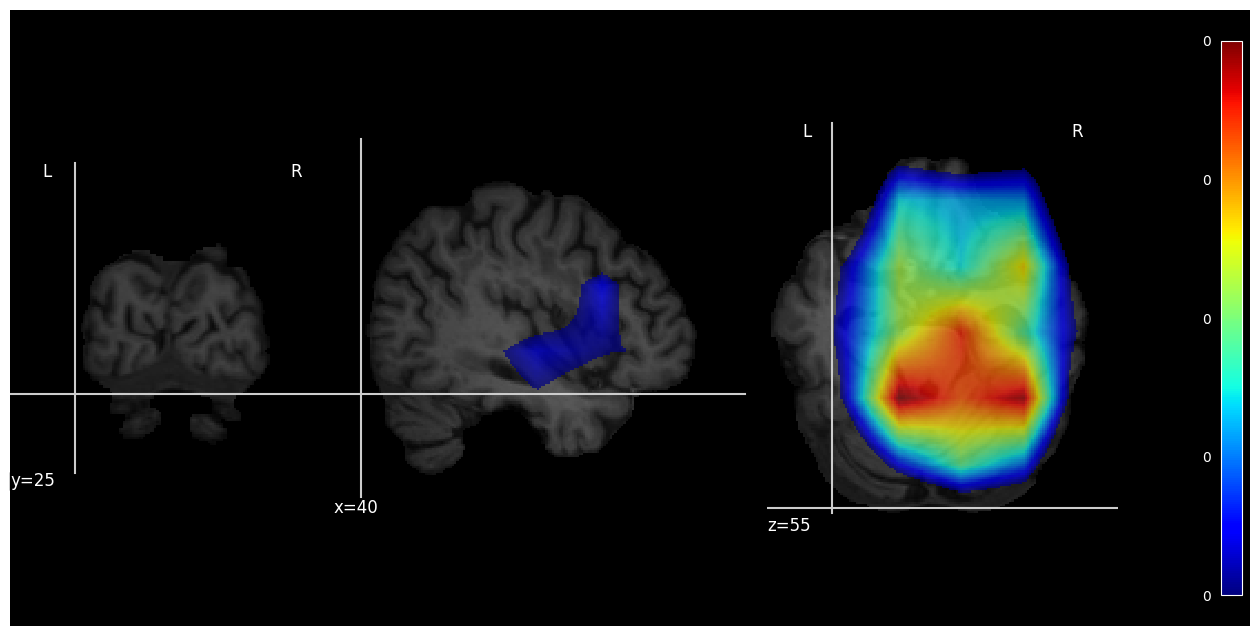

In [13]:
dataset_img = data_test.__getitem__(0)
display_interpretation(mean_1, dataset_img, threshold=0.30)